# Data Ingestion & Exploratory Analysis of the UFO Database

Unidentified Flying Objects (UFOs) have been an interesting topic for most enthusiasts and hence people all over the United States report such findings online at National UFO Report Center (NUFORC). Some of these reports are hoax and amongst those that seem legitimate, there isn’t currently an established method to confirm that they indeed are events related to flying objects from aliens in outer space. However, the database provides a wealth of information that can be exploited to provide various analyses and insights such as social reporting, identifying real-time spatial events and much more. We perform analysis to localize these time-series geospatial events and correlate with known real-time events. This paper does not confirm any legitimacy of alien activity, but rather attempts to gather information from likely legitimate reports of UFOs by studying the online reports. These events happen in geospatial clusters and also are time-based. We present a scheme consisting of feature extraction by filtering related datasets over a time-band of 24 hrs and use multi-dimensional textual summaries along with geospatial information to determine best clusters of UFO activity. Later, we look at cluster density and data visualization to search the space of various cluster realizations to decide best probable clusters that provide us information about proximity of such activity. A random forest classifier is also presented that is used to identify true events and hoax events, using the best possible features available such as region, week, time-period and duration. Lastly, we show the performance of the scheme on various days and discover interesting correlations with real-time events!

In [375]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import geocoder
import re
import math

The UFO database as you can see below has the following columns:
    * Date/Time of the event.
    * City where the event was reported.
    * State of the city.
    * Shape that the observer thought they saw.
    * Duration of the event.
    * Summary - description of the UFO event.
    * Date posted by the UFO website.

In [376]:
ufo_data = pd.read_csv("data/ufo/ufo_data.csv", sep='\t')
ufo_data.head()

,Date/Time,City,State,Shape,Duration,Summary,Posted
0,12/31/15 23:59,Eugene,OR,Fireball,7 minutes,Viewed 4 slow moving orange-ish orbs on new ye...,1/5/16
1,12/31/15 23:59,Salem,UT,Sphere,6 minutes,I was driving home from work and I saw 3 orang...,1/5/16
2,12/31/15 23:55,Fairbanks,AK,Circle,20 minutes,"Eight small circular craft near surface, seen ...",1/5/16
3,12/31/15 23:45,Port Saint Lucie,FL,Sphere,8 minutes,"Very odd. At about 11:45 pm on New Years Eve,...",1/8/16
4,12/31/15 23:00,Wilkes-Barre/Hazleton (between),PA,Oval,5 minutes,Low oval reddish pinkish lights came flying fr...,1/5/16


The data used in this research is collected and made public by the National UFO Reporting Center launched in 1974. The NUFORC site hosts an extensive database of UFO sighting reports that are submitted either online or though a 24-hour telephone hotline. The data undergoes an internal quality check by the NUFORC staff before being made public and, at the moment, presents one of the most comprehensive UFO reports databases available online. It provides the following information: Date/Time, City, State, Shape, Duration, Summary, and Posting date. The data gets occasionally used for local news reports as well as a broader-level reporting. 

The Date/Time needs to be parsed to extract the date components. The datetime utility cannot be easily used as the format of Date doesnt come with padded 0s for single digits.

In [377]:
ufo_data['Month'] = [int(r.split('/')[0]) for r in ufo_data['Date/Time']]
ufo_data['Day'] = [int(r.split('/')[1]) for r in ufo_data['Date/Time']]
ufo_data['Date'] = [(r.split(' ')[0]) for r in ufo_data['Date/Time']]
ufo_data['Time'] = [(r.split(' ')[-1]) for r in ufo_data['Date/Time']]

Let us convert the bin the events by time since the time of reporting is continous and by the minute. A binning of the events helps analyse statistics such as, how many events occurred during noon?

In [378]:
def time_period(time):
    '''
    Convert time into periods 1,2,...,12. If the time is hh: mm 
    and 2i<hh<2(i+1), then hh:mm belongs to period t.
    Suppose the time is 6:30am, since 2*3<6<2*4, then it belongs to period 3. 
    
    Args:
        time (time): Time period.
    Returns:
        periods (time): Formatted time period.
        
    '''
    periods=[]
    for t in time:
        try:
            p = int(t.split(':')[0])
            for i in range(12):
                if(p>=2*i) & (p<2*(i+1)):
                    periods.append(i+1)
        except ValueError:
                periods.append(-1)
    return periods  

ufo_data['TimePeriod'] = time_period(ufo_data['Time'])
ufo_data.head(1)

,Date/Time,City,State,Shape,Duration,Summary,Posted,Month,Day,Date,Time,TimePeriod
0,12/31/15 23:59,Eugene,OR,Fireball,7 minutes,Viewed 4 slow moving orange-ish orbs on new ye...,1/5/16,12,31,12/31/15,23:59,12


Let us look at events where durations are reported as null

In [379]:
null_data = ufo_data[ufo_data.Duration.isnull()]
null_data.head(1)

,Date/Time,City,State,Shape,Duration,Summary,Posted,Month,Day,Date,Time,TimePeriod
12,12/31/15 20:50,Albuquerque,NM,Circle,NaN,My husband and I were driving home and my husb...,1/5/16,12,31,12/31/15,20:50,11


In [380]:
def duration_sec(duration_text):
    '''
    Add a duration column with normalized units of measurement (seconds). Extracts the duration in seconds
    by infering the duration from the text.
    Args:
        text (str): String of text.
    Returns:
        (int): Time duration in seconds.
        
    '''
    try:
        metric_text = ["second","s","Second","minute","m","min","Minute","hour","h","Hour"]
        metric_seconds = [1,1,1,60,60,60,60,3600,3600,3600]
        for m,st in zip(metric_text, metric_seconds):
            regex = "\s*(\d+)\+?\s*{}s?".format(m)
            a = re.findall(regex, duration_text)
            if len(a)>0:
                return int(int(a[0]) * st)
            else:
                return None
    except:
        return None

## Impute duration column with mean

In [381]:
ufo_data["Duration_Sec"] = ufo_data["Duration"].apply(duration_sec)
ufo_data["Duration_Sec"] = ufo_data.Duration_Sec.fillna(int(ufo_data.Duration_Sec.mean()))
ufo_data['Duration_Sec'].unique()

array([  19.,   30.,    5.,   10.,   20.,   15.,    4.,    3.,   40.,
         45.,   90.,    1.,    2.,   12.,    6.,   60.,    8.,    7.,
         25.,  120.,   50.,   49.,   35.,  320.,   65.,    9.,  180.,
         14.,   75.,   48.,   84.,   55.,   11.,   72.,   32.,   17.,
         28.,  105.,   95.,   23.,   42.,  450.,   18.,   88.,   36.,
        110.,   70.,  155.,   78.,   80.,   13.,   22.,   37.,   85.,
         59.,   27.,   33.,   83.,   26.,   16.,   41.,  152.,  400.])

From the above you can see that there are no null values in Durations. 

Let us look at the unique states and which states are most reporting UFO events.

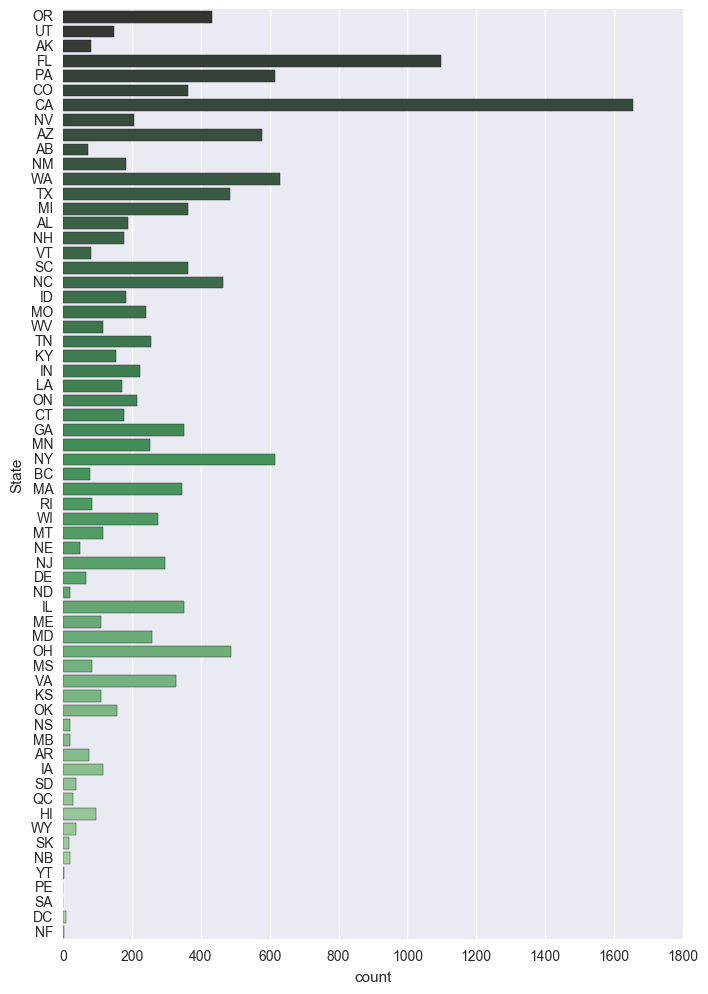

In [382]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 12))
sns.countplot(y="State", data=ufo_data, palette="Greens_d");

Let us look at how many of these are in the United States.

In [383]:
all_states = ufo_data['State'].value_counts(dropna=False) 
US = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE",
      "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY",
      "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT",
      "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH",
      "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT",
      "VT", "VA", "WA", "WV", "WI", "WY"]

print([state for state in all_states.index if state not in US])

[nan, 'ON', 'BC', 'AB', 'QC', 'MB', 'NS', 'NB', 'SK', 'YT', 'NF', 'PE', 'SA']


We can see from above that many states are outside of United States. Since we are looking to study most events that occurred in the United States, let us create a column "US".

In [384]:
def is_US(state):
    '''
    Check if the state is in United States or not.
    Args:
        state (str): state reported in UFO data.
    Returns:
        (boolean): True if state is in US or False otherwise.
        
    '''
    if state in US:
        return True
    else:
        return False

In [385]:
ufo_data['US'] = ufo_data['State'].apply(is_US)
ufo_data.head(1)

,Date/Time,City,State,Shape,Duration,Summary,Posted,Month,Day,Date,Time,TimePeriod,Duration_Sec,US
0,12/31/15 23:59,Eugene,OR,Fireball,7 minutes,Viewed 4 slow moving orange-ish orbs on new ye...,1/5/16,12,31,12/31/15,23:59,12,19.0,True


Let us see how much we stand to lose in terms of considering data inside of US by plotting a count plot with a hue.

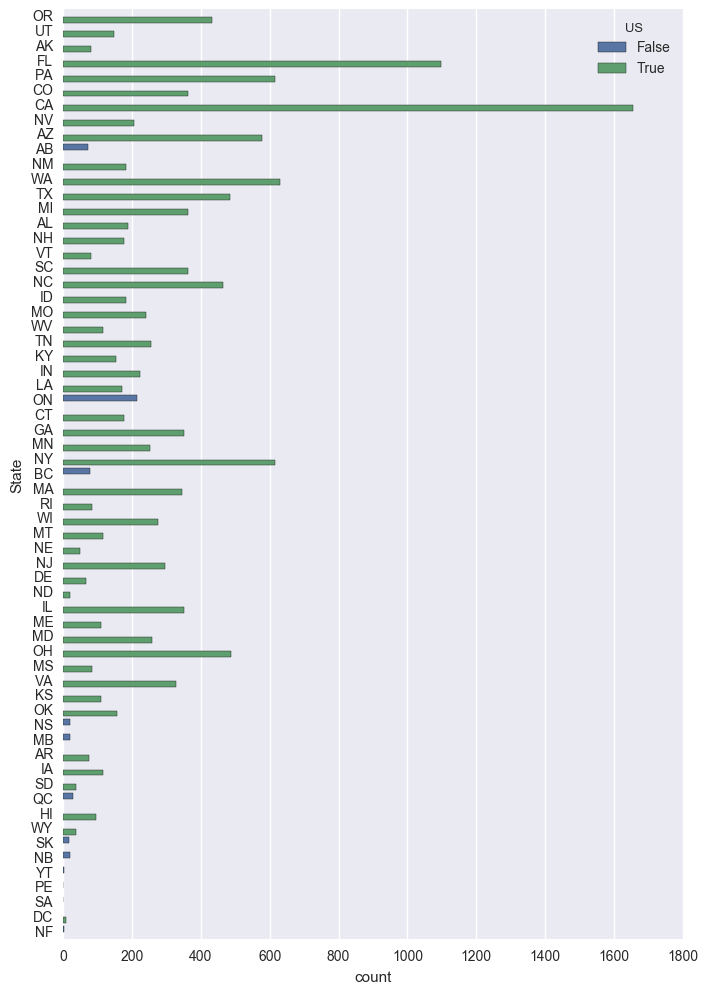

In [386]:
plt.figure(figsize=(8, 12))
g = sns.countplot(y="State", hue="US", data=ufo_data)

We can study from countplot that there is a small percentage of data that we stand to lose by ignoring states outisde of United States. Let us keep only states within US for our initial analysis.

In [387]:
ufo_data = ufo_data[ufo_data.US == 1]    

Let us explore how the city column looks. It is important to take a look at lots of values in the dataset to check for anomalies or data with noise. For example the city data has noise with text containing additional information within () and other such noises. 

In [388]:
#print(ufo_data['City'].unique()[0:1000])

Transfrom the City column to exclude all irrelevant text entries (e.g., additional comments).

In [389]:
def clean_city_data(city_name):
    '''
    Cleans the city string of additional comments and irrelevant data.
    
    Args:
        city_name (str): Name of the city
    Returns:
        (str): correct city name.
        
    '''
    try:
        city_name = city_name.split('/')[0]
        city_name = city_name.split('(')[0]
        city_name = city_name.split(',')[0]
        city_name = city_name.split('?')[0]
        return city_name
    except AttributeError:
        return 'Unknown'
    
ufo_data['City'].apply(clean_city_data)

0                   Eugene
1                    Salem
2                Fairbanks
3         Port Saint Lucie
4             Wilkes-Barre
5        Steamboat Springs
6             Saint George
7               Sacramento
8                Las Vegas
9               Titusville
10              Scottsdale
12             Albuquerque
13                 Menifee
14              Bellingham
15                Bay City
16               Ypsilanti
17                 Gadsden
18                  Canaan
19              Plainfield
20           Southwest UK 
21               Fairbanks
22                  Sequim
23              San Ysidro
25                Monmouth
26            Simpsonville
27           Bessemer City
28                 Olympia
29                   Miami
30              Post Falls
31                  Bangor
               ...        
15350         Jacksonville
15351         Rohnert Park
15352     Colorado Springs
15353                 Elon
15354         Mt. Pleasant
15355       Spokane Valley
1

## Latitude & Longitude of reported events.
These events are reported at various cities. We need the latitude and longitude information to perform geospatial analysis. A process of coverting an address to a latitude and longitude is called forward geocoding. The geopy library is useful for forward geocoding. It connects to a network and looks up the address and returns back the latitude and longitude information. The code below is used to determine the coordianates. We have already run the code below and generated a file. Hence, do not run this portion of the code below. Also it takes a while to look up all the addresses. 

#### Warning
Don't run this code as it is a placeholder; instead use data exported to a csv:data_coord.csv
This code was used to extract coordinates for each state-city combination. 

In [390]:
# from geopy.geocoders import ArcGIS
# from geopy.exc import GeocoderTimedOut

# Latitude=[]
# Longitude=[]
# geolocator = ArcGIS()
# fails=[]
# for i in range(len(df)):
#     try:
#         location = geolocator.geocode(df.iloc[i,1]+','+df.iloc[i,2])
#         df.iloc[i,-2] = location.latitude
#         df.iloc[i,-1] = location.longitude
#         print (i, location.address, df.iloc[i,-2], df.iloc[i,-1])
#         df.to_csv('data_coord_1.csv',sep='\t', encoding='utf-8', index=False)
#     except (AttributeError, GeocoderTimedOut) as e:
#         df.to_csv('data_coord_1.csv',sep='\t', encoding='utf-8', index=False)
#         print ('exception:', i)

Now that we have the cleaned and processed the data, let us extract right columns from the dataframe that are useful and shall be our features for modeling.

In [391]:
features = ['Date', 'Month', 'Day', 'Time', 'TimePer', 'City', 'State', 'Lat', 'Long',
            'Shape', 'Duration', 'Duration_Sec', 'Summary', 'Posted', 'US_STATE']

ufo_data = pd.DataFrame(ufo_data, columns = features)
ufo_data.head(1)

,Date,Month,Day,Time,TimePer,City,State,Lat,Long,Shape,Duration,Duration_Sec,Summary,Posted,US_STATE
0,12/31/15,12,31,23:59,NaN,Eugene,OR,NaN,NaN,Fireball,7 minutes,19.0,Viewed 4 slow moving orange-ish orbs on new ye...,1/5/16,NaN


In [392]:
ufo_data['Lat'] = np.nan
ufo_data['Long'] = np.nan

ufo_data = pd.read_csv("data/ufo/data_coord.csv", sep='\t')
ufo_data = ufo_data[(~ufo_data.Long.isnull()) & (~ufo_data.Lat.isnull())]

In [393]:
ufo_data['Date'] = pd.to_datetime(ufo_data['Date'])
ufo_data.set_index('Date', inplace=True)
ufo_data = ufo_data.reset_index()
ufo_data['WeekDay'] = ufo_data['Date'].dt.dayofweek
ufo_data['Week'] = ufo_data['Date'].dt.weekofyear
ufo_data['Quarter'] = ufo_data['Date'].dt.quarter
ufo_data['Year'] = ufo_data['Date'].dt.year

In [394]:
ufo_data.columns

Index(['Date', 'Date/Time', 'City', 'State', 'Shape', 'Duration', 'Summary',
       'Posted', 'Month', 'Day', 'Time', 'Periods', 'Duration_Sec', 'US_STATE',
       'Lat', 'Long', 'WeekDay', 'Week', 'Quarter', 'Year'],
      dtype='object')

## Adding other data sources
In order to have a better understanding of the UFO reports, let us add the following external-data sources: 
* dates of astronomical events in CY 2014-2015
* dates of national holidays in CY 2014-2015
* US state population and share of active military population per year per each state. 

### US state population and share of active military population per year per each state. 

In [395]:
ufo_stats = pd.read_excel("data/ufo/stats2.xlsx")
ufo_stats.head(2)

,state,state abbr,Number of Active Duty members 2014,2014 Popualtion,2015 Population,Share of pop 2014,Share of pop 2015,Region
0,Alabama,AL,7875,4846411,4858979,0.001625,0.001621,South
1,Alaska,AK,19608,737046,738432,0.026603,0.026554,West


We can now merge the two datasets on state abbreviations.

In [396]:
ufo_stats['State'] = ufo_stats['state abbr']
ufo_data = pd.merge(ufo_data, ufo_stats, on='State')
ufo_data.columns

Index(['Date', 'Date/Time', 'City', 'State', 'Shape', 'Duration', 'Summary',
       'Posted', 'Month', 'Day', 'Time', 'Periods', 'Duration_Sec', 'US_STATE',
       'Lat', 'Long', 'WeekDay', 'Week', 'Quarter', 'Year', 'state',
       'state abbr', 'Number of Active Duty members 2014', '2014 Popualtion',
       '2015 Population', 'Share of pop 2014', 'Share of pop 2015', 'Region'],
      dtype='object')

In [397]:
ufo_data.loc[ufo_data['Year'] == 2014, 'Pop'] = ufo_data['2014 Popualtion'][ufo_data['Year'] == 2014]
ufo_data.loc[ufo_data['Year'] == 2015, 'Pop'] = ufo_data['2015 Population'][ufo_data['Year'] == 2015]
ufo_data.loc[ufo_data['Year'] == 2014, 'Milit_Share'] = ufo_data['Number of Active Duty members 2014'][ufo_data['Year'] == 2014]/ufo_data['2014 Popualtion'][ufo_data['Year'] == 2014]
ufo_data.loc[ufo_data['Year'] == 2015, 'Milit_Share'] = ufo_data['Number of Active Duty members 2014'][ufo_data['Year'] == 2015]/ufo_data['2015 Population'][ufo_data['Year'] == 2015]

## Hoax Prediction

The inevitable presence of IFO reports in the dataset can, in fact, be considered an added value, since the non-UFO reports are still indicative of actual events taking place. Therefore, our analysis focuses on the events that are reported as UFOs, regardless of them being an alien activity or in future recognized as an IFO. In addition to general reporting trends, the analysis of NUFORC data can offer insight into the UFO perception and their validity as some of the latter are labeled to be hoax reports by NUFORC. 

In [398]:
#Adding a Hoax column derived from the Summary column
pattern = '|'.join(["HOAX","NUFORC Note"])
ufo_data['Validity'] = ufo_data.Summary.str.contains(pattern)

def binary_convert(value):
    if value==True:
        return 0
    else:
        return 1
    
ufo_data['Validity'] = ufo_data['Validity'].apply(lambda x: binary_convert(x))

In [399]:
ufo_data_hoax = ufo_data[['Summary','Validity']]
ufo_data_hoax[ufo_data_hoax.Validity==0].shape

(862, 2)

### Average reports during the day per state grouped by Time.

/Users/harishkashyap/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


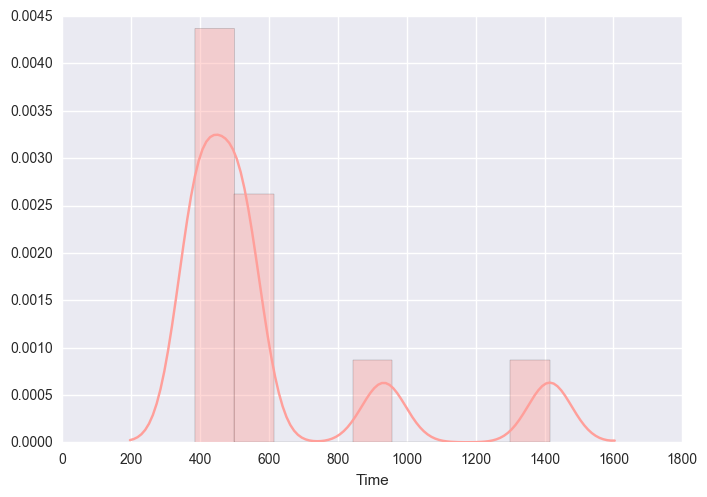

In [400]:
# sns.set(style="white", palette="muted", color_codes=True)
g = sns.distplot(ufo_data.groupby(['State'])['Time'].count().nlargest(10), color="r")

### Violin plots of reports on weekdays vs weekends
Create a categorical variable column called WeekEnd. Violin plots showcase the distribution of events that aren't hoax over the weekdays vs weekends. This will be a large plot as we can get information about the density of reports in all states.

In [401]:
ufo_data['WeekEnd'] = "WeekDay"
ufo_data.ix[ufo_data['WeekDay']>4, 'WeekEnd'] = "WeekEnd"

Let us look at the states which reported the highest UFO events and look at their violin plots.

In [438]:
ufo_states = ufo_data.groupby('State')['Year'].count().nlargest(10)

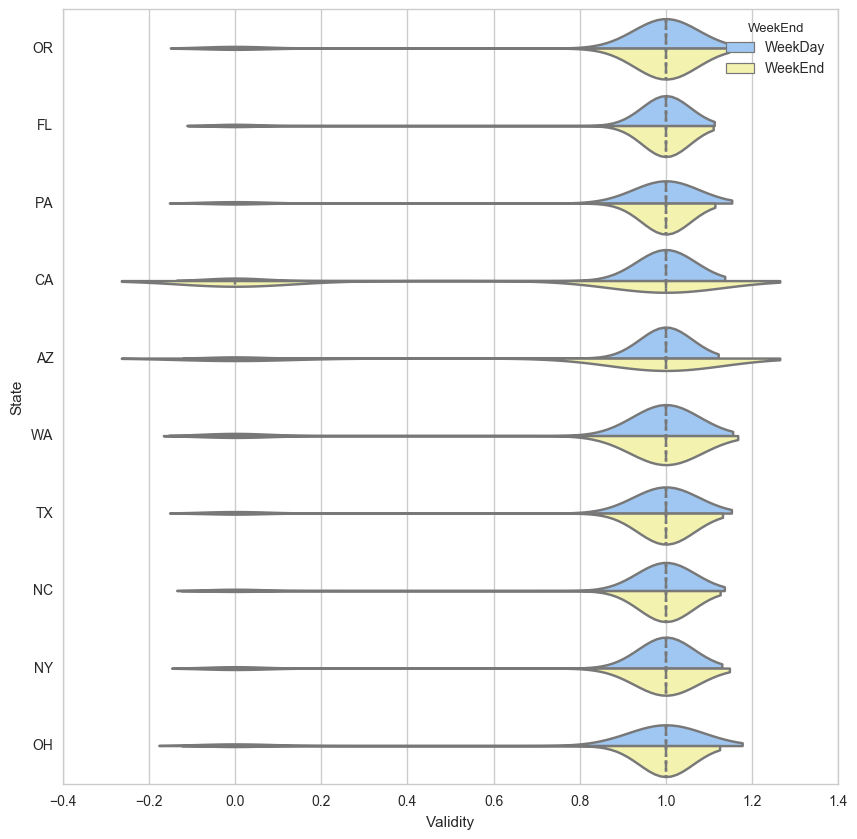

In [443]:
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(y="State", x="Validity", hue="WeekEnd", 
               data=ufo_data.loc[ufo_data['State'].isin(ufo_states.index.tolist())], 
               split=True, inner="quart", palette={"WeekDay": "b", "WeekEnd": "y"})

### Reports of various shapes in a violin plot on a weekday vs weekend.

Let us look at the largest shapes reported.

In [447]:
ufo_shapes = ufo_data.groupby('Shape')['Year'].count().nlargest(10)
print(ufo_shapes)

Shape
Light        2670
Circle       1589
Fireball     1299
Triangle     1006
Sphere        851
Unknown       849
Other         713
Oval          463
Formation     439
Disk          399
Name: Year, dtype: int64


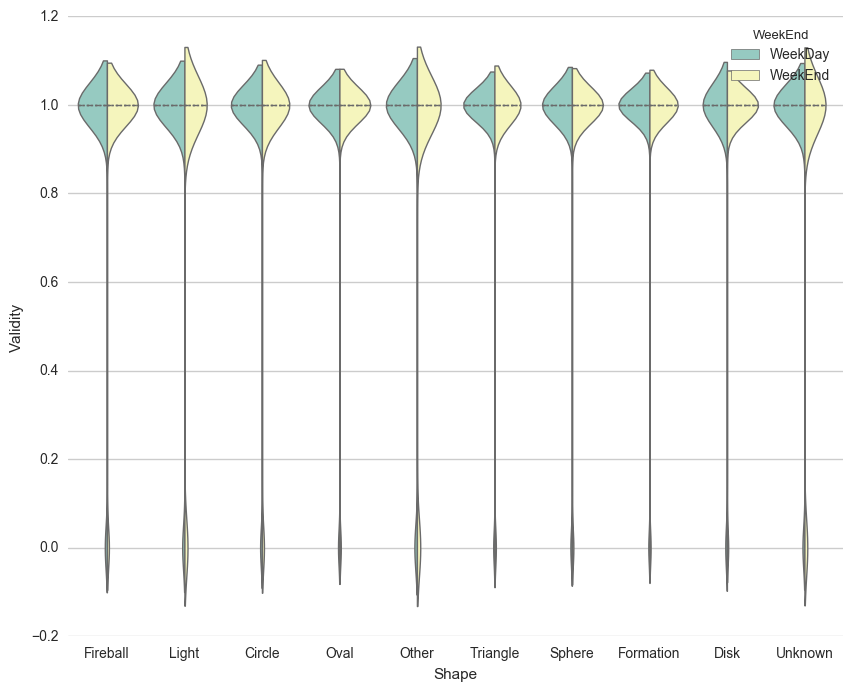

In [451]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(y="Validity", x="Shape", hue="WeekEnd", data=ufo_data.loc[ufo_data['Shape'].isin(ufo_shapes.index.tolist())],
               split=True, inner="quart", palette="Set3", bw=.2, cut=2, linewidth=1)

# Finalize the figure
sns.despine(left=True, bottom=True)

Remove the rows where State or City is unknown. Alternatively impute the rows for missing values.

In [ ]:
ufo_data = ufo_data[~ufo_data.State.isnull() & ~ufo_data.City.isnull()]
ufo_data.isnull().sum()

In [ ]:
import folium

# Get a basic world map.
UFOmap = folium.Map(location=[30, 0], zoom_start=2)
# Draw markers on the map.
for name, row in ufo_data.iterrows():
    UFOmap.circle_marker(location=[row["Lat"], row["Long"]], popup=row["City"])
# Create and show the map.
UFOmap.create_map('UFOmap.html')
UFOmap